In [1]:
import pandas as pd   
import numpy as np
import seaborn as sns
import pandas.util.testing as tm
import matplotlib.pyplot as plt
%matplotlib inline
sns.set()

/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
breeds = pd.read_csv('data/breed_labels.csv')
color = pd.read_csv('data/color_labels.csv')
state = pd.read_csv('data/state_labels.csv')

train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test/test.csv')
sub = pd.read_csv('data/test/sample_submission.csv')

# EDA

In [3]:
breeds.head()

,BreedID,Type,BreedName
0,1,1,Affenpinscher
1,2,1,Afghan Hound
2,3,1,Airedale Terrier
3,4,1,Akbash
4,5,1,Akita


In [4]:
breeds.nunique()

BreedID      307
Type           2
BreedName    307
dtype: int64

There are 307 unique breed names in the dataset. They are classified into two types. 1 means dog, cat is 2.

In [5]:
print(color)
print(f"Number of unique colors of the animals are: ",color["ColorName"].nunique())

   ColorID ColorName
0        1     Black
1        2     Brown
2        3    Golden
3        4    Yellow
4        5     Cream
5        6      Gray
6        7     White
Number of unique colors of the animals are:  7


This color dataset contains the color of the animals. There are 7 unique colors in all.

In [6]:
state.head()

,StateID,StateName
0,41336,Johor
1,41325,Kedah
2,41367,Kelantan
3,41401,Kuala Lumpur
4,41415,Labuan


In [7]:
print(f"States represented in the dataset are:",state["StateName"].nunique())

States represented in the dataset are: 15


In [8]:
train.head().T

,0,1,2,3,4
Type,2,2,1,1,1
Name,Nibble,No Name Yet,Brisco,Miko,Hunter
Age,3,1,1,4,1
Breed1,299,265,307,307,307
Breed2,0,0,0,0,0
Gender,1,1,1,2,1
Color1,1,1,2,1,1
Color2,7,2,7,2,0
Color3,0,0,0,0,0
MaturitySize,1,2,2,2,2


In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14993 entries, 0 to 14992
Data columns (total 24 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Type           14993 non-null  int64  
 1   Name           13736 non-null  object 
 2   Age            14993 non-null  int64  
 3   Breed1         14993 non-null  int64  
 4   Breed2         14993 non-null  int64  
 5   Gender         14993 non-null  int64  
 6   Color1         14993 non-null  int64  
 7   Color2         14993 non-null  int64  
 8   Color3         14993 non-null  int64  
 9   MaturitySize   14993 non-null  int64  
 10  FurLength      14993 non-null  int64  
 11  Vaccinated     14993 non-null  int64  
 12  Dewormed       14993 non-null  int64  
 13  Sterilized     14993 non-null  int64  
 14  Health         14993 non-null  int64  
 15  Quantity       14993 non-null  int64  
 16  Fee            14993 non-null  int64  
 17  State          14993 non-null  int64  
 18  Rescue

In [10]:
# Missing values
total = train.isnull().sum().sort_values(ascending=False)
percent = ((train.isnull().sum()/train.isnull().count()) * 100).sort_values(ascending=False)
missing_values = pd.concat([total,percent], axis=1, keys = ["total","percent"])
print("Sorted missing values in descending order:")
missing_values.head(20)

Sorted missing values in descending order:


,total,percent
Name,1257,8.383912
Description,12,0.080037
AdoptionSpeed,0,0.000000
FurLength,0,0.000000
Age,0,0.000000
Breed1,0,0.000000
Breed2,0,0.000000
Gender,0,0.000000
Color1,0,0.000000
Color2,0,0.000000


The dataset is mostly numeric. Names has about 8.38% of missing entries, since they are strayed animals and they can't say their names. It is quite understandable. I might take out th ones with missing description since the dataset is large enough. I am planning to do some sentiment analysis to see how the description helps with adoption speed.

### Which pet types are the most strayed?

In [11]:
df_train = train.copy()
df_train["Type"] = df_train["Type"].replace({1: "Dog", 2: "Cat"})
df_train["AdoptionSpeed"] = df_train["AdoptionSpeed"].replace({0: "Same Day", 1: "1-7 days",
                        2:"8 - 30 days", 3: "31-90 days",4:"> 100 days - None"})
df_train["Health"] = df_train["Health"].replace({1: "Healthy", 2: "Minor injury",
                            3:"Serious injury", 0:"Not specified"})
df_train["Vaccinated"] = df_train["Vaccinated"].replace({1: "Yes", 2: "No",
                            3:"Not sure"})
df_train["Gender"] = df_train["Gender"].replace({1: "Male", 2: "Female",
                            3:"Mixed"})
df_train["Color1"] = df_train["Color1"].replace({1: "Black", 2: "Brown",
                            3:"Golden", 4:"Yellow", 5:"Cream", 6: "Gray", 7:"White"})
df_train["Color2"] = df_train["Color2"].replace({1: "Black", 2: "Brown",
                            3:"Golden", 4:"Yellow", 5:"Cream", 6: "Gray", 7:"White"})
df_train["MaturitySize"] = df_train["MaturitySize"].replace({1: "Small", 2: "Medium",
                            3:"Large", 4:"X-Large", 0:"Not specified"}) 
df_train["FurLength"] = df_train["FurLength"].replace({1: "Short", 2: "Medium",
                            3:"Long",0:"Not specified"}) 
df_train["Dewormed"] = df_train["Dewormed"].replace({1: "Yes", 2: "No",
                            3:"Not sure"})
df_train["Sterilized"] = df_train["Sterilized"].replace({1: "Yes", 2: "No",
                            3:"Not sure"})



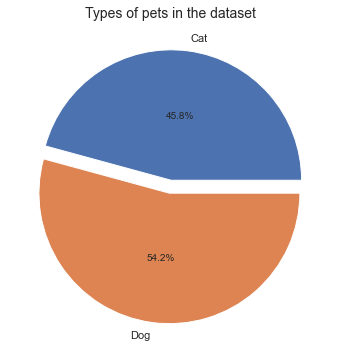

In [12]:
pet_type = df_train.groupby("Type").count()
pie, ax = plt.subplots(figsize=[10,6])
labels = pet_type["Breed1"].keys()
plt.pie(x=pet_type["Breed1"], autopct="%.1f%%", explode=[0.05]*2, labels=labels, pctdistance=0.5)
plt.title("Types of pets in the dataset", fontsize=14);

### Which pets have the fastest adoption speed?

In [33]:
fast_adoption = df_train.groupby("AdoptionSpeed").count().reset_index()
fast_adoption

,AdoptionSpeed,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,...,Sterilized,Health,Quantity,Fee,State,RescuerID,VideoAmt,Description,PetID,PhotoAmt
0,1-7 days,3090,2819,3090,3090,3090,3090,3090,3090,3090,...,3090,3090,3090,3090,3090,3090,3090,3088,3090,3090
1,31-90 days,3259,3043,3259,3259,3259,3259,3259,3259,3259,...,3259,3259,3259,3259,3259,3259,3259,3258,3259,3259
2,8 - 30 days,4037,3725,4037,4037,4037,4037,4037,4037,4037,...,4037,4037,4037,4037,4037,4037,4037,4032,4037,4037
3,> 100 days - None,4197,3765,4197,4197,4197,4197,4197,4197,4197,...,4197,4197,4197,4197,4197,4197,4197,4193,4197,4197
4,Same Day,410,384,410,410,410,410,410,410,410,...,410,410,410,410,410,410,410,410,410,410


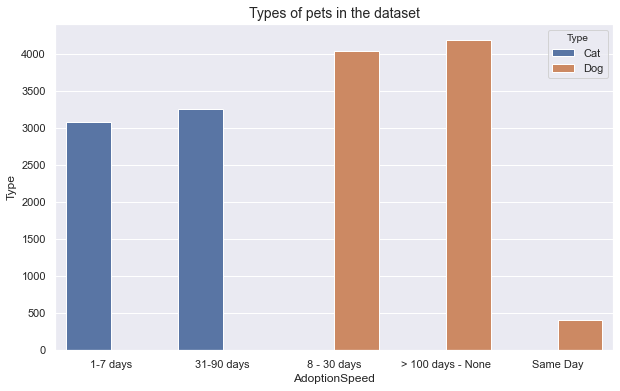

In [29]:
plt.subplots(figsize=[10,6])
#plt.pie(x=fast_adoption["Type"], autopct="%.1f%%", explode=[0.05]*5, labels=labels, pctdistance=0.5)
ax = sns.barplot(x=fast_adoption["AdoptionSpeed"], y=fast_adoption["Type"], hue=df_train["Type"])
plt.title("Types of pets in the dataset", fontsize=14);

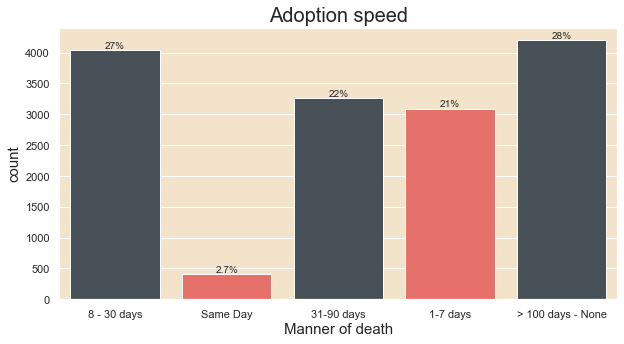

In [15]:
plt.figure(figsize=(10,5))
ax = sns.countplot(x='AdoptionSpeed', data=df_train,palette=['#445159','#fa5f56'])
plt.title('Adoption speed', size=20)
plt.xlabel('Manner of death', size=15)
#plt.yticks(size=12)
plt.ylabel('count',size=15)
ax.set_facecolor("#f3e3cb")
# fig.patch.set_facecolor("green")
# fig.patch.set_alpha(1)
for p in ax.patches:
    x = p.get_bbox().get_points()[:,0]
    y = p.get_bbox().get_points()[1,1]
    ax.annotate('{:.2g}%'.format(100.*y/len(df_train)), (x.mean(), y), ha='center', va='bottom')
#plt.savefig('manner_of_death.png',dpi = 1000)
plt.show()